Survival analysis
=================

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from pathlib import Path
import sys
import inspect

local = Path("..").resolve() if (Path("..") / "data").exists() else Path(".")

In [3]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.float_format', lambda x: '%.3f' % x)


<ipython-input-3-b73db489d492>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


## C 60 data exploration ##

In [5]:
from pathlib import Path
data = local / "data"
input = data / "input"
output = data / "output"
input.absolute()

PosixPath('/data/sources/C60/data/input')

In [39]:
mice = pd.read_csv(input / "lifespan.tsv", na_values = "NA", sep="\t")
mice.head(10)


,lifespan,intervention,gender,died_from_aging
0,438,water,male,1
1,449,water,male,1
2,450,water,male,1
3,494,water,male,1
4,521,water,male,1
5,556,water,male,1
6,580,water,male,1
7,623,water,male,1
8,639,water,male,1
9,670,water,male,1


Drawing the curves
=============

In [418]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import *

In [71]:
mice_males = mice[mice["gender"]=="male"]
mice_females = mice[mice["gender"]=="female"]
mice_females.head(10)

,lifespan,intervention,gender,died_from_aging
113,408,water,female,1
114,412,water,female,1
115,485,water,female,1
116,492,water,female,1
117,516,water,female,1
118,518,water,female,1
119,543,water,female,1
120,603,water,female,1
121,636,water,female,1
122,651,water,female,1


In [47]:
mice_water = mice[mice["intervention"] == "water"]
mice_C60 =  mice[mice.intervention == "С60"]
mice_oil =  mice[mice["intervention"] == "oil"]
mice_C60.head(10)

,lifespan,intervention,gender,died_from_aging
76,464,С60,male,1
77,501,С60,male,1
78,506,С60,male,1
79,533,С60,male,1
80,587,С60,male,1
81,615,С60,male,1
82,653,С60,male,1
83,666,С60,male,1
84,688,С60,male,1
85,689,С60,male,1


In [72]:
mice_water_males = mice_males[mice_males["intervention"] == "water"]
mice_C60_males =  mice_males[mice_males.intervention == "С60"]
mice_oil_males =  mice_males[mice_males["intervention"] == "oil"]
mice_C60_males.head(10)

,lifespan,intervention,gender,died_from_aging
76,464,С60,male,1
77,501,С60,male,1
78,506,С60,male,1
79,533,С60,male,1
80,587,С60,male,1
81,615,С60,male,1
82,653,С60,male,1
83,666,С60,male,1
84,688,С60,male,1
85,689,С60,male,1


In [73]:
mice_water_females = mice_females[mice_females["intervention"] == "water"]
mice_C60_females =  mice_females[mice_females.intervention == "С60"]
mice_oil_females =  mice_females[mice_females["intervention"] == "oil"]
mice_C60_females.head(10)

,lifespan,intervention,gender,died_from_aging
191,447,С60,female,1
192,464,С60,female,1
193,570,С60,female,1
194,574,С60,female,1
195,584,С60,female,1
196,586,С60,female,1
197,633,С60,female,1
198,645,С60,female,1
199,654,С60,female,1
200,657,С60,female,1


Plotting
========

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import *

In [51]:
mice.lifespan.shape

(226,)

<AxesSubplot:title={'center':'Survival curve of all female mice'}, xlabel='timeline'>

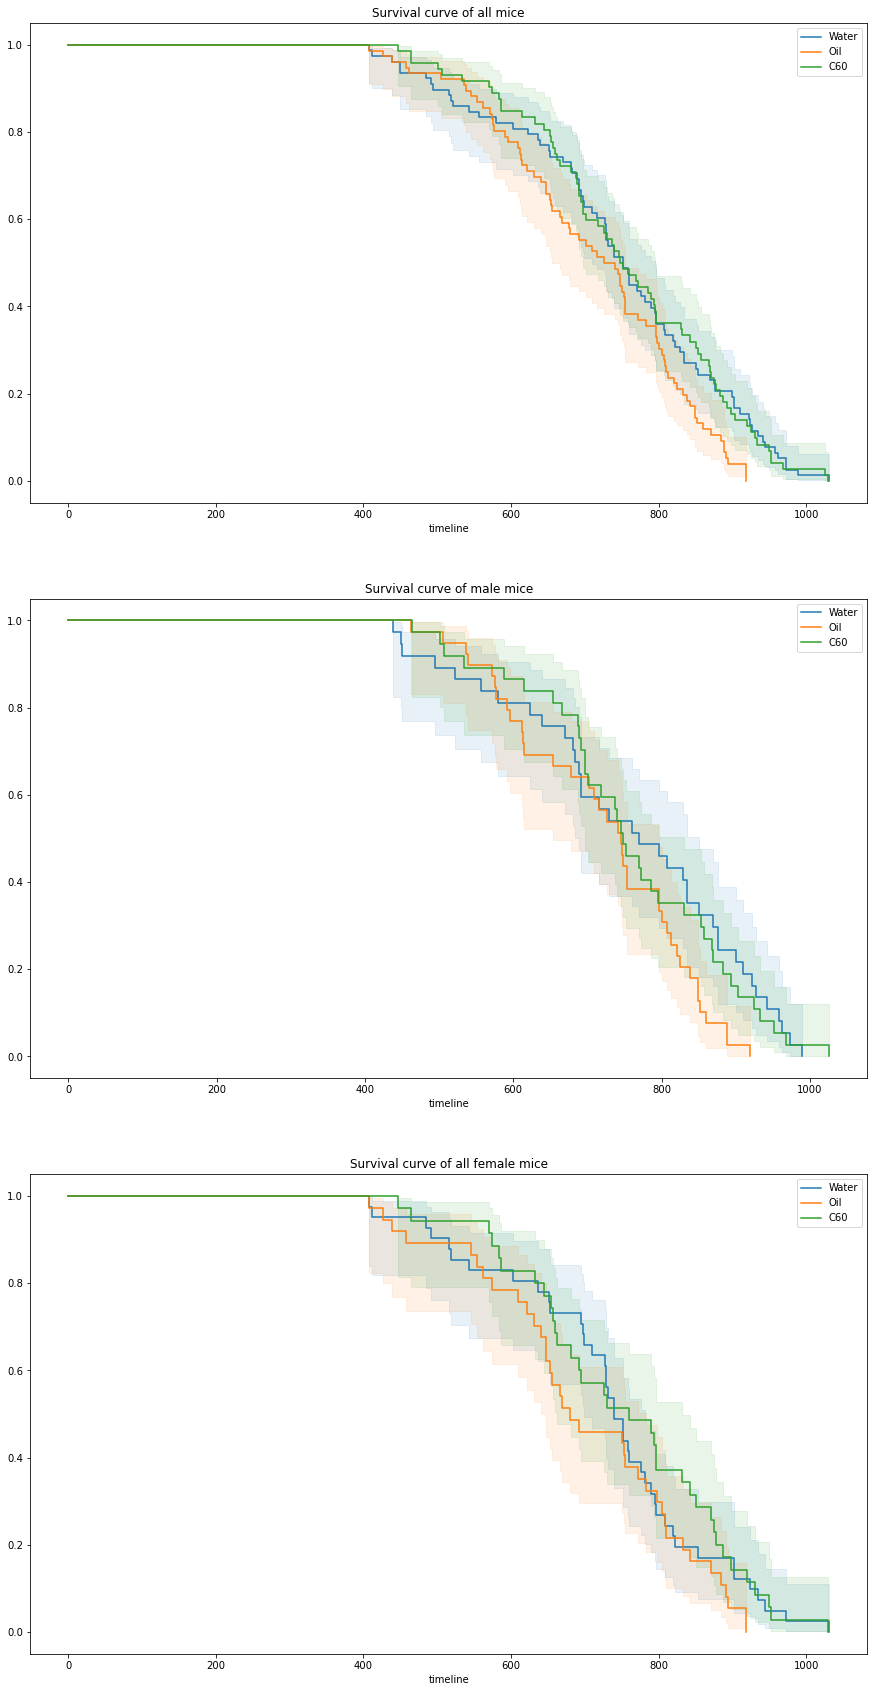

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(15, 30))
kmf = KaplanMeierFitter()        

#ALL
kmf.fit(mice_water["lifespan"], event_observed = mice_water["died_from_aging"], label="Water")   
kmf.plot_survival_function(ax=axes[0], ci_alpha=0.1)    
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

kmf.fit(mice_oil["lifespan"], event_observed = mice_oil["died_from_aging"], label="Oil")   
kmf.plot_survival_function(ax=axes[0],  ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1)

kmf.fit(mice_C60["lifespan"], event_observed = mice_C60["died_from_aging"], label="C60")   
kmf.plot_survival_function(ax=axes[0], title= "Survival curve of all mice", ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[0][1], ci_alpha = 0.1, title="Cumulative density for all mice")


#Males

kmf.fit(mice_water_males["lifespan"], event_observed = mice_water_males["died_from_aging"], label="Water")   
kmf.plot_survival_function(ax=axes[1], ci_alpha=0.1)    
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)


kmf.fit(mice_oil_males["lifespan"], event_observed = mice_oil_males["died_from_aging"], label="Oil")   
kmf.plot_survival_function(ax=axes[1], ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1)


kmf.fit(mice_C60_males["lifespan"], event_observed = mice_C60_males["died_from_aging"], label="C60")   
kmf.plot_survival_function(ax=axes[1], title= "Survival curve of male mice", ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[1][1], ci_alpha = 0.1, title="Cumulative density for male mice")


#Females
kmf.fit(mice_water_females["lifespan"], event_observed = mice_water_females["died_from_aging"], label="Water")   
kmf.plot_survival_function(ax=axes[2], ci_alpha=0.1)    
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)


kmf.fit(mice_oil_females["lifespan"], event_observed = mice_oil_females["died_from_aging"], label="Oil")   
kmf.plot_survival_function(ax=axes[2], ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1)


kmf.fit(mice_C60_females["lifespan"], event_observed = mice_C60_females["died_from_aging"], label="C60")   
kmf.plot_survival_function(ax=axes[2], title= "Survival curve of all female mice", ci_alpha=0.1)
#kmf.plot_cumulative_density(ax=axes[2][1], ci_alpha = 0.1, title="Cumulative density for female mice")





Statistical analysis
--------------------
Reproducing paper's statistical analysis

Pairwise logrank test
=====================

In [121]:
pairwise_logrank_test(mice["lifespan"], mice["intervention"], mice["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
oil   water            6.26 0.01      6.34
      С60              6.92 0.01      6.88
water С60              0.00 0.95      0.08

In [123]:
pairwise_logrank_test(mice_males["lifespan"], mice_males["intervention"], mice_males["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
oil   water            5.37 0.02      5.61
      С60              3.36 0.07      3.91
water С60              0.07 0.79      0.34

In [127]:
pairwise_logrank_test(mice_females["lifespan"], mice_females["intervention"], mice_females["died_from_aging"])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
oil   water            1.56 0.21      2.24
      С60              3.41 0.06      3.95
water С60              0.11 0.73      0.44

Multivariate logrank test
=========================

In [130]:
multivariate_logrank_test(mice["lifespan"], mice["intervention"], mice["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           8.35 0.02      6.02

In [128]:
multivariate_logrank_test(mice_males["lifespan"], mice_males["intervention"], mice_males["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.20 0.20      2.31

In [129]:
multivariate_logrank_test(mice_females["lifespan"], mice_females["intervention"], mice_females["died_from_aging"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.20 0.20      2.31

At fixed point in time
======================

In [ ]:
#lifelines.statistics.survival_difference_at_fixed_point_in_time_test